In this notebook, we will try to train an LSTM model using API-Calls from android applications.

<h1>Loading Data</h1>

<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train using API-Calls.
For convenience, here on out we will use the already exported data.

In [72]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import joblib


# Read the CSV file
df = pd.read_csv('api_calls_labeled_dataset.csv')

In [73]:
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, replace=True, random_state=42)
other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True, random_state=42)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples]).reset_index(drop=True)
df['detection'].value_counts()

/tmp/ipykernel_18948/3930063033.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True, random_state=42)).reset_index(drop=True)


detection
benign      1000
adware       200
exploit      200
hacktool     200
spyware      200
trojan       200
Name: count, dtype: int64

In [66]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = label_encoder.fit_transform(df['detection'])

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Convert sequences to numerical representations
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length
max_seq_length = 500

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [67]:
# Fit and transform the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['detection'])

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Save the label encoder and tokenizer
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(tokenizer, 'tokenizer.pkl')


['tokenizer.pkl']

In [74]:
# Load the label encoder and tokenizer
label_encoder = joblib.load('./Models/lstm-model/label_encoder.pkl')
tokenizer = joblib.load('./Models/lstm-model/tokenizer.pkl')

# Transform the labels and sequences using the loaded encoders
labels = label_encoder.transform(df['detection'])
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length and pad the sequences
max_seq_length = 500
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [75]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)


Training set shape: (1600, 500)
Validation set shape: (400, 500)
Training labels shape: (1600,)
Validation labels shape: (400,)


<h1>Training LSTM</h1>

In [69]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/kreunt/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [71]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.4624 - loss: 1.6285 - val_accuracy: 0.5900 - val_loss: 1.0166
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5942 - loss: 1.0548 - val_accuracy: 0.7150 - val_loss: 0.7868
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.6959 - loss: 0.7701 - val_accuracy: 0.6925 - val_loss: 0.7765
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7185 - loss: 0.7041 - val_accuracy: 0.7475 - val_loss: 0.6242
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8132 - loss: 0.5218 - val_accuracy: 0.8150 - val_loss: 0.5388
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.8756 - loss: 0.4082 - val_accuracy: 0.8400 - val_loss: 0.4867
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9331 - loss: 0.2655 - val_accuracy: 0.8625 - val_loss: 0.4367
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9489 - loss: 0.1928 - val_accuracy: 0.87

In [76]:
from keras.models import load_model

# Load the pre-trained LSTM model
model = load_model('./Models/lstm-model/model.keras')


In [77]:
from sklearn.metrics import classification_report

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict on the validation set
y_pred_probs = model.predict(X_val)
y_pred = np.zeros_like(y_pred_probs)
y_pred[np.arange(len(y_pred_probs)), y_pred_probs.argmax(axis=1)] = 1

# Generate a classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))




Validation Loss: 0.4575043022632599
Validation Accuracy: 0.8949999809265137
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Classification Report:
              precision    recall  f1-score   support

      adware       0.71      0.71      0.71        34
      benign       0.95      0.95      0.95       199
     exploit       0.80      0.97      0.88        33
    hacktool       0.92      1.00      0.96        44
     spyware       0.89      0.85      0.87        48
      trojan       0.82      0.67      0.74        42

   micro avg       0.90      0.90      0.90       400
   macro avg       0.85      0.86      0.85       400
weighted avg       0.90      0.90      0.89       400
 samples avg       0.90      0.90      0.90       400



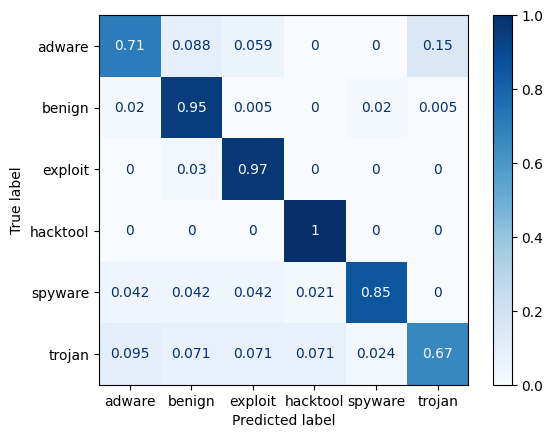

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure y_true and y_pred are in class index format
y_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class indices


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')



In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'history' is not defined

<Figure size 1000x600 with 0 Axes>

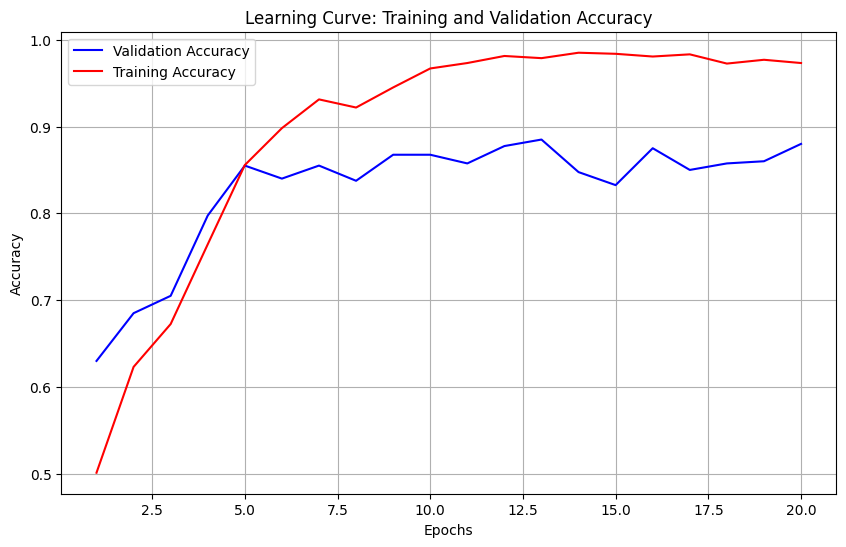

In [248]:
# Extract validation and training accuracy from history
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r-', label='Training Accuracy')
plt.title('Learning Curve: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [249]:
model.save('model.keras')